# Risk-aware GUMDPs

In [1]:
import os
import math
import json
import itertools
import numpy as np
import matplotlib
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs.envs import get_env

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

In [2]:
def sample_trajectory(env, policy, traj_length):
    # Args:
    # env - env specification.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s = np.random.choice(env["states"], p=env["p_0"])

    for t in range(traj_length):
        states.append(s)

        a = np.random.choice(env["actions"], p=policy[s])
        actions.append(a)

        s =  np.random.choice(env["states"], p=env["P"][a,s,:])

    return states, actions

In [3]:
def estimate_d_pi_from_trajectory(env, trajectory_states, trajectory_actions):
    # Args:
    # env - env specification.
    # trajectory_states - list with sampled states.
    # trajectory_actions - list with sampled actions.
    
    nS = len(env["states"])
    nA = len(env["actions"])

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += env["gamma"]**t * 1

        d_hats.append(((1 - env["gamma"])/(1 - env["gamma"]**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [4]:
def estimate_f_d_pi_from_samples(env, policy, N, max_traj_length, K=1):
    # Args:
    # env - env specification.
    # policy - policy specification (np.array).
    # N - number of times K trajectories are sampled.
    # K - number of trajectories to sample.
    # max_traj_length - the maximum length of each sampled trajectory.

    nS = len(env["states"])
    nA = len(env["actions"])

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(env, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(env, traj_states, traj_actions)
        d_hat = d_hat / K

        # Compute f(d_hat).
        #d_hat_flattened = d_hat.reshape((max_traj_length,-1)) # [max_traj_length, nS, nA]
        f_d_hat = np.array([env["f"](x) for x in d_hat])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [18]:
def calculate_erm(dist, beta):
    return (1.0 / beta) * np.log( (1/len(dist)) * np.sum(np.exp(beta*dist)) )

In [6]:
""" def cvar_ci(samples: np.ndarray, confidence_level : float, num_resamples: int=25_000):
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True).T
    # print("resampled.shape", resampled.shape)
    var_thresholds = np.percentile(resampled, (1-confidence_level) * 100, axis=1)
    # print("var_thresholds", var_thresholds)
    # print("len(var_thresholds)", len(var_thresholds))
    tail_losses_indicators = resampled >= var_thresholds[:, np.newaxis]
    # print("tail_losses_indicators", tail_losses_indicators)
    # print("tail_losses_indicators.shape", tail_losses_indicators.shape)
    resampled[~tail_losses_indicators] = np.nan
    # print("resampled", resampled)
    # print("resampled.shape", resampled.shape)
    cvars = np.nanmean(resampled, axis=1)

    confidence_interval = [np.percentile(cvars, 5),
                            np.percentile(cvars, 95)]

    return confidence_interval """

### Entropy maximization MDP

In [19]:
def create_policies(N=10):
    policies = []
    base_policy = np.array([[0.0, 1.0], [np.nan, np.nan], [1.0, 0.0], [0.5, 0.5]])
    for x in np.linspace(0.0, 1.0, N):
        base_policy_copy = np.copy(base_policy)
        base_policy_copy[1,0] = x
        base_policy_copy[1,1] = 1 - x
        policies.append(base_policy_copy)

    return policies

In [20]:
N = 50 # TODO
MAX_TRAJ_LENGTH = 500

env = get_env("entropy_mdp")

DATA = []

policies = create_policies()
# print(policies)
for policy in policies:
    estimated_f_d_pi = estimate_f_d_pi_from_samples(env, policy, N=N, max_traj_length=MAX_TRAJ_LENGTH)
    DATA.append({"policy": policy, "estimated_f_d_pi": estimated_f_d_pi})

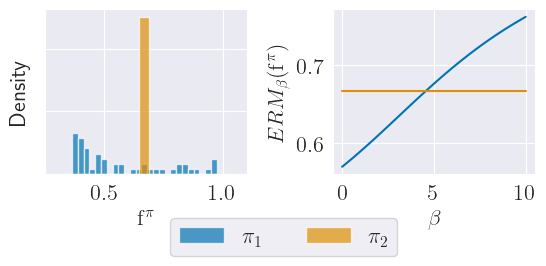

In [36]:
POLICY_1_IDX = 6
POLICY_2_IDX = 9


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(6.0, 2.5)
fig.tight_layout()


ax1.hist(DATA[POLICY_1_IDX]["estimated_f_d_pi"][:,-1], density=True, bins=25, alpha=0.7, label=r'$\pi_1$')
ax1.hist(DATA[POLICY_2_IDX]["estimated_f_d_pi"][:,-1], density=True, bins=25, alpha=0.7, label=r'$\pi_2$')

ax1.set_xlabel(r'$\mathrm{f}^{\pi}$');
ax1.set_ylabel('Density');
ax1.grid()
ax1.legend(ncol=2, bbox_to_anchor=(1.8, -0.2))
ax1.set_xlim(0.25,1.1)
ax1.set_yticklabels([])

for (policy_idx, policy_lbl) in zip([POLICY_1_IDX,POLICY_2_IDX], [r'$\pi_1$', r'$\pi_2$']):
    betas = np.linspace(0.01, 10.0, 100)
    ys = []
    for beta in betas:
        ys.append(calculate_erm(DATA[policy_idx]["estimated_f_d_pi"][:,-1], beta=beta))
    
    ax2.plot(betas, ys, label=policy_lbl)

ax2.grid()
# ax2.legend()
ax2.set_xlabel(r'$\beta$');
ax2.set_ylabel(r'$ERM_\beta(\mathrm{f}^{\pi})$');

plt.savefig("erm_motivating_example_entropy.pdf", bbox_inches='tight')

plt.show()

In [ ]:
exp_steps = 1_000

""" mcts_planner_paths = {
    0.05: "entropy_mdp_mcts_gamma_0.9_alpha_0.05_2025-07-09-16-11-37",
    0.1: "entropy_mdp_mcts_gamma_0.9_alpha_0.1_2025-07-09-16-28-04",
    0.2: "entropy_mdp_mcts_gamma_0.9_alpha_0.2_2025-07-09-16-44-41",
    0.3: "entropy_mdp_mcts_gamma_0.9_alpha_0.3_2025-07-09-17-01-17",
    0.4: "entropy_mdp_mcts_gamma_0.9_alpha_0.4_2025-07-09-17-17-50",
    0.5: "entropy_mdp_mcts_gamma_0.9_alpha_0.5_2025-07-09-16-17-21",
    0.6: "entropy_mdp_mcts_gamma_0.9_alpha_0.6_2025-07-09-16-33-47",
    0.7: "entropy_mdp_mcts_gamma_0.9_alpha_0.7_2025-07-09-16-50-13",
    0.8: "entropy_mdp_mcts_gamma_0.9_alpha_0.8_2025-07-09-17-06-49",
    0.9: "entropy_mdp_mcts_gamma_0.9_alpha_0.9_2025-07-09-17-23-23",
    0.95: "entropy_mdp_mcts_gamma_0.9_alpha_0.95_2025-07-09-17-39-53",
} """

""" mcts_planner_paths = {
    0.05: "entropy_mdp_mcts_gamma_0.9_alpha_0.05_2025-07-10-15-11-19",
    0.1: "entropy_mdp_mcts_gamma_0.9_alpha_0.1_2025-07-10-15-26-50",
    0.2: "entropy_mdp_mcts_gamma_0.9_alpha_0.2_2025-07-10-15-42-34",
    0.3: "entropy_mdp_mcts_gamma_0.9_alpha_0.3_2025-07-10-15-58-04",
    0.4: "entropy_mdp_mcts_gamma_0.9_alpha_0.4_2025-07-10-16-13-44",
    0.5: "entropy_mdp_mcts_gamma_0.9_alpha_0.5_2025-07-10-16-29-31",
    0.6: "entropy_mdp_mcts_gamma_0.9_alpha_0.6_2025-07-10-19-06-43",
    0.7: "entropy_mdp_mcts_gamma_0.9_alpha_0.7_2025-07-10-19-22-20",
    0.8: "entropy_mdp_mcts_gamma_0.9_alpha_0.8_2025-07-10-19-37-35",
    0.9: "entropy_mdp_mcts_gamma_0.9_alpha_0.9_2025-07-10-19-52-43",
    0.95: "entropy_mdp_mcts_gamma_0.9_alpha_0.95_2025-07-10-20-08-08",
} """

mcts_planner_paths = {
    0.05: "entropy_mdp_mcts_gamma_0.99_alpha_0.05_2025-08-04-15-17-56",
    0.1: "entropy_mdp_mcts_gamma_0.99_alpha_0.1_2025-08-04-15-53-57",
    0.5: "entropy_mdp_mcts_gamma_0.99_alpha_0.5_2025-08-04-16-29-31",
    0.9: "entropy_mdp_mcts_gamma_0.99_alpha_0.9_2025-08-04-17-05-20",
    0.95: "entropy_mdp_mcts_gamma_0.99_alpha_0.95_2025-08-04-17-41-30",
}

mcts_planner_data = {}

for cvar_alpha, mcts_path in mcts_planner_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()
    mcts_planner_data[cvar_alpha] = mcts_plan_data

# print(mcts_planner_data)

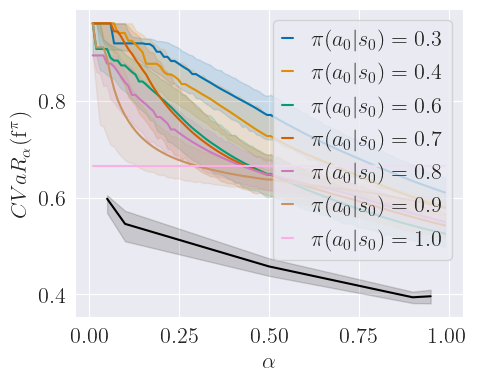

In [11]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

pol_idxs_to_plot = [3,4,5,6,7,8,9]

for pol_idx in pol_idxs_to_plot:

    # print("Policy: ", DATA[pol_idx]["policy"])
    alphas = np.linspace(0.01, 0.99, 100)
    ys = []
    cis = []
    for alpha in alphas:
        ys.append(calculate_cvar(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha))
        cis.append(cvar_ci(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha, num_resamples=1_000))
    
    p = plt.plot(alphas, ys, label=fr"$\pi(a_0|s_0)={round(policies[pol_idx][1,0],1)}$")

    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                        color=p[0].get_color(), alpha=0.15)

xs, ys = [], []
cis = []
for cvar_alpha, mcts_data in mcts_planner_data.items():
    cvar_value = calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha)
    cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha, num_resamples=1_000))
    ys.append(cvar_value)
    xs.append(cvar_alpha)   
p = plt.plot(xs, ys, c='black')
cis = np.array(cis)
plt.fill_between(mcts_planner_data.keys(), cis[:,0], cis[:,1],
                    color=p[0].get_color(), alpha=0.15)
    
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=1, handlelength=0.5)
plt.grid()
#plt.savefig("cvar_entropy_plot.pdf", bbox_inches='tight')
plt.show()

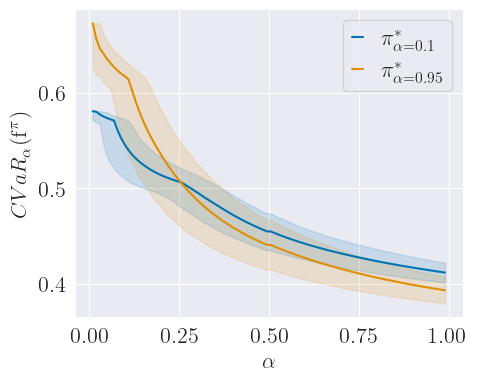

In [20]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for cvar_alpha, mcts_data in mcts_planner_data.items():

    if cvar_alpha not in [0.1, 0.95]:
        continue

    alphas = np.linspace(0.01,0.99,100)

    cis = []
    ys = []
    for alpha in alphas:
        ys.append(calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=alpha))
        cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=alpha, num_resamples=20_000))

    p = plt.plot(alphas, ys, label=rf"$\pi^*_{{\alpha={cvar_alpha}}}$")
    
    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                        color=p[0].get_color(), alpha=0.15)
    
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=1, handlelength=0.5)
plt.grid()
#plt.savefig("cvar_entropy_plot.pdf", bbox_inches='tight')
plt.show()

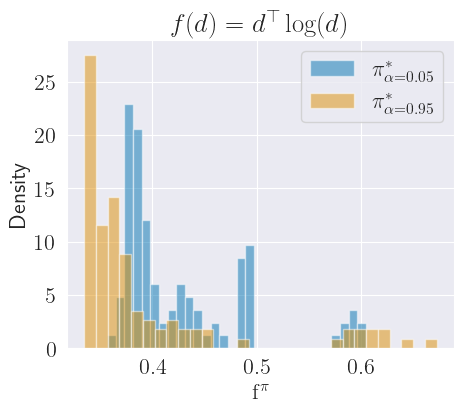

In [18]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(mcts_planner_data[0.05]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.05}$')
#plt.hist(mcts_planner_data[0.5]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.5}$')
# plt.hist(mcts_planner_data[0.9]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.9}$')
plt.hist(mcts_planner_data[0.95]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.95}$')
plt.ylabel('Density')
plt.xlabel(r'$\mathrm{f}^{\pi}$');
plt.grid()

plt.legend()

plt.title(r'$f(d) = d^\top \log(d)$')
# plt.savefig("f_dist_entropy_example.pdf", bbox_inches='tight')
plt.show()

### Linear MDP

In [7]:
def create_policies(N=10):
    policies = []
    '''base_policy = np.array([[np.nan, np.nan], [0.2, 0.8], [0.2, 0.8], [0.5, 0.5]])
    for x in np.linspace(0.01, 0.99, N):
        base_policy_copy = np.copy(base_policy)
        base_policy_copy[0,0] = x
        base_policy_copy[0,1] = 1 - x
        policies.append(base_policy_copy)'''
    policies.append(np.array([[0.01, 0.99], [0.2, 0.8], [0.2, 0.8], [0.5, 0.5]]))
    policies.append(np.array([[0.4, 0.6], [0.2, 0.8], [0.2, 0.8], [0.5, 0.5]]))
    policies.append(np.array([[0.7, 0.3], [0.2, 0.8], [0.2, 0.8], [0.5, 0.5]]))
    policies.append(np.array([[0.99, 0.01], [0.2, 0.8], [0.2, 0.8], [0.5, 0.5]]))
    return policies

In [8]:
N = 100
MAX_TRAJ_LENGTH = 100

env = get_env("linear_mdp")

DATA = []
policies = create_policies()
#print(policies)
for policy in policies:
    estimated_f_d_pi = estimate_f_d_pi_from_samples(env, policy, N=N, max_traj_length=MAX_TRAJ_LENGTH)
    DATA.append({"policy": policy, "estimated_f_d_pi": estimated_f_d_pi})

In [9]:
exp_steps = 1_000

#mcts_planner_paths = {
#    0.05: "linear_mdp_mcts_gamma_0.9_alpha_0.05_2025-07-07-12-06-04",
#    0.1: "linear_mdp_mcts_gamma_0.9_alpha_0.1_2025-07-07-12-20-45",
#    0.2: "linear_mdp_mcts_gamma_0.9_alpha_0.2_2025-07-07-12-35-22",     
#    0.3: "linear_mdp_mcts_gamma_0.9_alpha_0.3_2025-07-07-12-50-07",     
#    0.4: "linear_mdp_mcts_gamma_0.9_alpha_0.4_2025-07-07-13-06-15",
#    0.5: "linear_mdp_mcts_gamma_0.9_alpha_0.5_2025-07-07-13-20-54",
#    0.6: "linear_mdp_mcts_gamma_0.9_alpha_0.6_2025-07-07-12-07-45",
#    0.7: "linear_mdp_mcts_gamma_0.9_alpha_0.7_2025-07-07-12-22-55",
#    0.8: "linear_mdp_mcts_gamma_0.9_alpha_0.8_2025-07-07-12-37-41",
#    0.9: "linear_mdp_mcts_gamma_0.9_alpha_0.9_2025-07-07-12-53-52",
#    0.95: "linear_mdp_mcts_gamma_0.9_alpha_0.95_2025-07-07-13-08-53",
#}

mcts_planner_paths = {
    0.05: "linear_mdp_mcts_gamma_0.9_alpha_0.05_2025-07-10-11-19-10",
    0.1: "linear_mdp_mcts_gamma_0.9_alpha_0.1_2025-07-10-11-33-36",
    0.2: "linear_mdp_mcts_gamma_0.9_alpha_0.2_2025-07-10-11-48-18",
    0.3: "linear_mdp_mcts_gamma_0.9_alpha_0.3_2025-07-10-12-03-13",
    0.4: "linear_mdp_mcts_gamma_0.9_alpha_0.4_2025-07-10-12-18-03",
    0.5: "linear_mdp_mcts_gamma_0.9_alpha_0.5_2025-07-10-12-57-03",
    0.6: "linear_mdp_mcts_gamma_0.9_alpha_0.6_2025-07-10-13-11-00",
    0.7: "linear_mdp_mcts_gamma_0.9_alpha_0.7_2025-07-10-13-24-38",
    0.8: "linear_mdp_mcts_gamma_0.9_alpha_0.8_2025-07-10-13-38-07",
    0.9: "linear_mdp_mcts_gamma_0.9_alpha_0.9_2025-07-10-13-51-47",
    0.95: "linear_mdp_mcts_gamma_0.9_alpha_0.95_2025-07-10-14-05-32",
}
mcts_planner_data = {}

for cvar_alpha, mcts_path in mcts_planner_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()
    mcts_planner_data[cvar_alpha] = mcts_plan_data

# print(mcts_planner_data[0.9])

##########################################################################

ravi_planner_path = "linear_mdp_ravi_gamma_0.9_2025-07-08-17-32-12"

# Load RAVI planner data and MDP.
with open("data/" + ravi_planner_path + "/exp_data.json", 'r') as f:
    ravi_planner_data = json.load(f)
    ravi_planner_data = json.loads(ravi_planner_data)
f.close()

# print(ravi_planner_data["f_vals_alphas"])

Policy:  [[0.01 0.99]
 [0.2  0.8 ]
 [0.2  0.8 ]
 [0.5  0.5 ]]
Policy:  [[0.4 0.6]
 [0.2 0.8]
 [0.2 0.8]
 [0.5 0.5]]
Policy:  [[0.7 0.3]
 [0.2 0.8]
 [0.2 0.8]
 [0.5 0.5]]
Policy:  [[0.99 0.01]
 [0.2  0.8 ]
 [0.2  0.8 ]
 [0.5  0.5 ]]


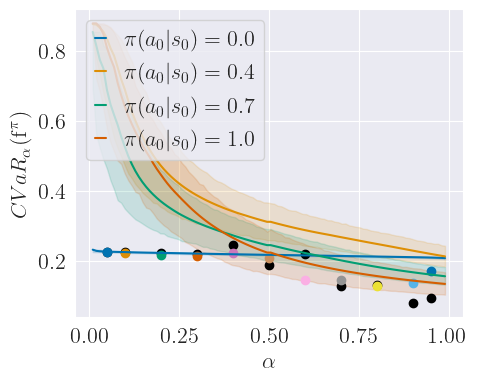

In [13]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

pol_idxs_to_plot = [0,1,2,3]

for pol_idx in pol_idxs_to_plot:

    print("Policy: ", DATA[pol_idx]["policy"])
    alphas = np.linspace(0.01,0.99,100)
    ys = []
    cis = []
    for alpha in alphas:
        #print(DATA[pol_idx]["estimated_f_d_pi"][:,-1])
        ys.append(calculate_cvar(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha))
        cis.append(cvar_ci(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha, num_resamples=5_000))

    p = plt.plot(alphas, ys, label=r'$\pi(a_0|s_0) = {}$'.format(round(DATA[pol_idx]["policy"][0,0],1)))

    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                         color=p[0].get_color(), alpha=0.15)

for cvar_alpha, mcts_data in mcts_planner_data.items():
    cvar_value = calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha)
    plt.scatter(cvar_alpha, cvar_value, c='black')

for cvar_alpha, f_vals in ravi_planner_data["f_vals_alphas"].items():
    cvar_alpha = float(cvar_alpha)
    cvar_value = calculate_cvar(np.array(f_vals), confidence_level=cvar_alpha)
    plt.scatter(cvar_alpha, cvar_value)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=2, handlelength=0.5)
plt.grid()
# plt.savefig("cvar_linear_mdp_plot.pdf", bbox_inches='tight')

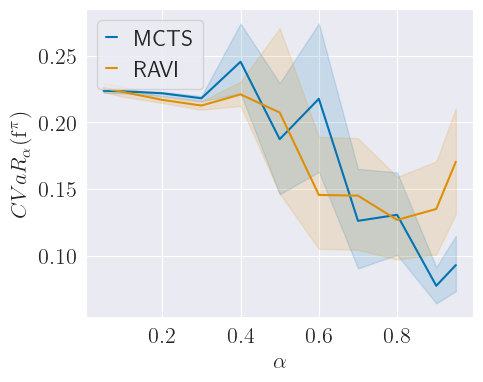

In [15]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

cis = []
xs = []
ys = []
for cvar_alpha, mcts_data in mcts_planner_data.items():
    cvar_value = calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha)
    ys.append(cvar_value)
    xs.append(cvar_alpha)
    cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha, num_resamples=10_000))

p = plt.plot(xs, ys, label="MCTS")
cis = np.array(cis)
plt.fill_between(xs, cis[:,0], cis[:,1],
                     color=p[0].get_color(), alpha=0.15)

cis = []
xs = []
ys = []
for cvar_alpha, f_vals in ravi_planner_data["f_vals_alphas"].items():
    cvar_alpha = float(cvar_alpha)
    cvar_value = calculate_cvar(np.array(f_vals), confidence_level=cvar_alpha)
    ys.append(cvar_value)
    xs.append(cvar_alpha)
    cis.append(cvar_ci(np.array(f_vals), confidence_level=cvar_alpha, num_resamples=10_000))

p = plt.plot(xs, ys, label="RAVI")
cis = np.array(cis)
plt.fill_between(xs, cis[:,0], cis[:,1],
                     color=p[0].get_color(), alpha=0.15, label="")

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=2, handlelength=0.5)
plt.grid()
# plt.savefig("cvar_linear_mdp_plot.pdf", bbox_inches='tight')

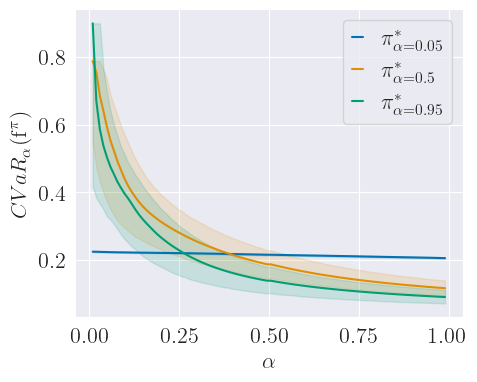

In [14]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for cvar_alpha, mcts_data in mcts_planner_data.items():

    if cvar_alpha not in [0.05, 0.5, 0.95]:
        continue

    alphas = np.linspace(0.01,0.99,100)

    cis = []
    ys = []
    for alpha in alphas:
        ys.append(calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=alpha))
        cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=alpha, num_resamples=20_000))

    p = plt.plot(alphas, ys, label=rf"$\pi^*_{{\alpha={cvar_alpha}}}$")
    
    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                        color=p[0].get_color(), alpha=0.15)
    
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=1, handlelength=0.5)
plt.grid()
#plt.savefig("cvar_entropy_plot.pdf", bbox_inches='tight')
plt.show()

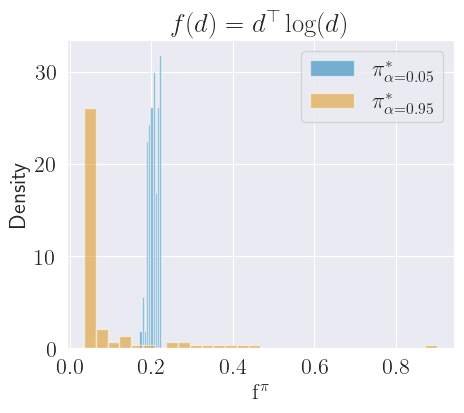

In [15]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(mcts_planner_data[0.05]["f_vals"], density=True, bins=10, alpha=0.5, label=r'$\pi^*_{\alpha=0.05}$')
#plt.hist(mcts_planner_data[0.1]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.1}$')
#plt.hist(mcts_planner_data[0.9]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.9}$')
plt.hist(mcts_planner_data[0.95]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.95}$')
plt.ylabel('Density')
plt.xlabel(r'$\mathrm{f}^{\pi}$');
plt.grid()

plt.legend()

plt.title(r'$f(d) = d^\top \log(d)$')
# plt.savefig("f_dist_entropy_example.pdf", bbox_inches='tight')
plt.show()

### Imitation learning MDP

In [7]:
def create_policies(N=10):
    policies = []
    base_policy = np.array([[np.nan, np.nan], [0.2, 0.8], [0.3, 0.7], [0.7, 0.3]])
    for x in np.linspace(0.01, 0.99, N):
        base_policy_copy = np.copy(base_policy)
        base_policy_copy[0,0] = x
        base_policy_copy[0,1] = 1 - x
        policies.append(base_policy_copy)

    return policies

# create_policies()

In [8]:
N = 100
MAX_TRAJ_LENGTH = 1_000

env = get_env("imitation_learning_mdp")

DATA = []
policies = create_policies()
# print(policies)
for policy in policies:
    estimated_f_d_pi = estimate_f_d_pi_from_samples(env, policy, N=N, max_traj_length=MAX_TRAJ_LENGTH)
    DATA.append({"policy": policy, "estimated_f_d_pi": estimated_f_d_pi})

In [9]:
exp_steps = 1_000

mcts_planner_paths = {
    0.05: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.05_2025-07-07-17-38-21",
    0.1: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.1_2025-07-07-17-53-04",
    0.2: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.2_2025-07-07-18-07-51",     
    0.3: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.3_2025-07-07-18-22-40",     
    0.4: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.4_2025-07-07-18-37-35",
    0.5: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.5_2025-07-07-18-52-22",
    0.6: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.6_2025-07-07-17-40-44",
    0.7: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.7_2025-07-07-17-55-38",
    0.8: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.8_2025-07-07-18-11-34",
    0.9: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.9_2025-07-07-18-25-55",
    0.95: "imitation_learning_mdp_mcts_gamma_0.9_alpha_0.95_2025-07-07-18-40-28",
}

mcts_planner_data = {}

for cvar_alpha, mcts_path in mcts_planner_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()
    mcts_planner_data[cvar_alpha] = mcts_plan_data

# print(mcts_planner_data)

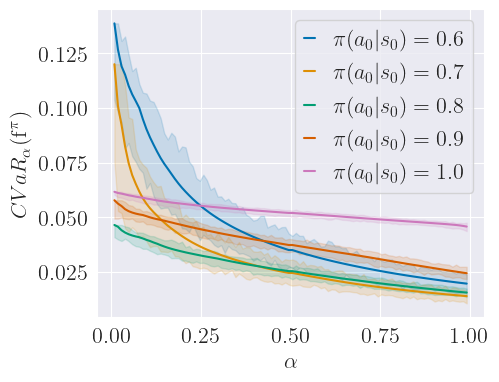

In [10]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

pol_idxs_to_plot = [5,6,7,8,9]

for pol_idx in pol_idxs_to_plot:

    # print("Policy: ", DATA[pol_idx]["policy"])
    alphas = np.linspace(0.01,0.99,100)
    ys = []
    cis = []
    for alpha in alphas:
        ys.append(calculate_cvar(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha))
        cis.append(cvar_ci(DATA[pol_idx]["estimated_f_d_pi"][:,-1], confidence_level=alpha, num_resamples=100))

    p = plt.plot(alphas, ys, label=fr"$\pi(a_0|s_0)={round(policies[pol_idx][0,0],1)}$")

    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                        color=p[0].get_color(), alpha=0.15)

#for cvar_alpha, mcts_data in mcts_planner_data.items():
#    cvar_value = calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=cvar_alpha)
#    plt.scatter(cvar_alpha, cvar_value, c='black')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#          ncol=2, fancybox=True, shadow=True)
plt.legend(loc=1, handlelength=0.5)
plt.grid()
# plt.savefig("cvar_imitation_learning_plot.pdf", bbox_inches='tight')

In [ ]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for cvar_alpha, mcts_data in mcts_planner_data.items():

    if cvar_alpha not in [0.1, 0.5, 0.9]:
        continue

    alphas = np.linspace(0.01,0.99,100)

    cis = []
    ys = []
    for alpha in alphas:
        ys.append(calculate_cvar(np.array(mcts_data["f_vals"]), confidence_level=alpha))
        cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=alpha, num_resamples=20_000))

    p = plt.plot(alphas, ys, label=rf"$\pi^*_{{\alpha={cvar_alpha}}}$")
    
    cis = np.array(cis)
    plt.fill_between(alphas, cis[:,0], cis[:,1],
                        color=p[0].get_color(), alpha=0.15)
    
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$CVaR_\alpha(\mathrm{f}^\pi)$')
plt.legend(loc=1, handlelength=0.5)
plt.grid()
#plt.savefig("cvar_entropy_plot.pdf", bbox_inches='tight')
plt.show()

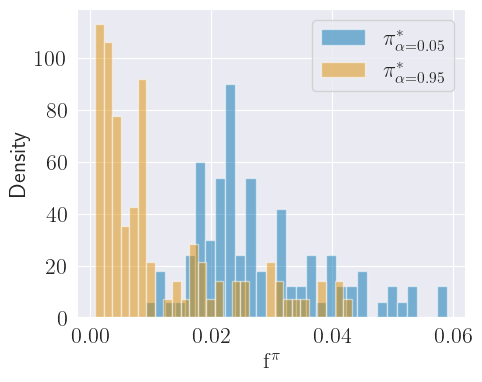

In [12]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(mcts_planner_data[0.05]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.05}$')
#plt.hist(mcts_planner_data[0.1]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.1}$')
#plt.hist(mcts_planner_data[0.9]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.9}$')
plt.hist(mcts_planner_data[0.95]["f_vals"], density=True, bins=30, alpha=0.5, label=r'$\pi^*_{\alpha=0.95}$')
plt.ylabel('Density')
plt.xlabel(r'$\mathrm{f}^{\pi}$');
plt.grid()

plt.legend()

# plt.savefig("f_dist_entropy_example.pdf", bbox_inches='tight')
plt.show()